In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


**1. Load Dataset**

In [46]:
# Adjust the filename if needed
df = pd.read_csv('synthetic_invoice_pairs.csv', 
                 parse_dates=['INV1_INVOICE_DATE','INV2_INVOICE_DATE'])
print("Loaded:", df.shape)
df.head()


Loaded: (5000, 23)


,INV1_VENDOR_NAME,INV1_VENDOR_ID,INV1_AMOUNT,INV1_CURRENCY,INV1_INVOICE_DATE,INV1_DESCRIPTION,INV1_PURCHASE_ORDER,INV1_COMPANY_CODE,INV1_COST_CENTER,INV1_TAX_CODE,...,INV2_AMOUNT,INV2_CURRENCY,INV2_INVOICE_DATE,INV2_DESCRIPTION,INV2_PURCHASE_ORDER,INV2_COMPANY_CODE,INV2_COST_CENTER,INV2_TAX_CODE,INV2_PAYMENT_TERMS,label
0,Cooper Ltd,VE1489,633.22,USD,2025-01-31,Heavy town money.,PO9276,1000,CC525,B1,...,626.60,USD,2025-01-31,Heavy town money.,PO9276,1000,CC525,B1,NET30,1
1,"Diaz, Anderson and Browning",VE1316,1369.83,GBP,2024-09-16,Military place edge environmental even eye mes...,PO8146,1000,CC275,A0,...,1368.64,GBP,16/09/2024,Military place edge environmental even eye mes...,PO8146,1000,CC275,A0,NET60,1
2,Patton-Jenkins,VE1110,2460.07,EUR,2024-12-27,Perhaps lawyer interest star his difficult.,PO2577,2000,CC862,B1,...,2464.33,EUR,27/12/2024,Perhaps lawyer interest star his difficult.,PO2577,2000,CC862,B1,NET60,1
3,Graham Group,VE1404,1904.09,GBP,2024-11-08,Feeling surface girl expert report include.,PO7972,1000,CC882,A0,...,1922.51,GBP,11-08-2024,Feeling surface girl expert report include.,PO7972,1000,CC882,A0,NET60,1
4,Sandoval-Cunningham,VE1081,1850.76,EUR,2024-06-30,Service throughout spring film look during mys...,PO4325,2000,CC382,A0,...,1825.69,EUR,06-30-2024,Service throughout spring film look during mys...,PO4325,2000,CC382,A0,NET30,1


**2. Text Preprocessing for SBERT**

In [47]:
def invoice_to_text(row, prefix='INV1'):
    date = row[f'{prefix}_INVOICE_DATE']
    # ensure string
    ds = date.strftime('%Y-%m-%d') if hasattr(date, 'strftime') else str(date)
    return (
        f"Vendor: {row[f'{prefix}_VENDOR_NAME']} ({row[f'{prefix}_VENDOR_ID']})\n"
        f"Amount: {row[f'{prefix}_AMOUNT']} {row[f'{prefix}_CURRENCY']}\n"
        f"Date: {ds}\n"
        f"Description: {row[f'{prefix}_DESCRIPTION']}\n"
        f"PO: {row[f'{prefix}_PURCHASE_ORDER']}\n"
        f"Company: {row[f'{prefix}_COMPANY_CODE']}, Cost Center: {row[f'{prefix}_COST_CENTER']}\n"
        f"Tax: {row[f'{prefix}_TAX_CODE']}, Terms: {row[f'{prefix}_PAYMENT_TERMS']}"
    )

df['text1'] = df.apply(lambda r: invoice_to_text(r, 'INV1'), axis=1)
df['text2'] = df.apply(lambda r: invoice_to_text(r, 'INV2'), axis=1)


**3.  Industry-specific rules**

In [48]:
# Exact‐match amount
df['same_amount'] = (df['INV1_AMOUNT'] == df['INV2_AMOUNT']).astype(int)
# % difference
df['pct_diff'] = (df['INV1_AMOUNT'] - df['INV2_AMOUNT']).abs() / df['INV1_AMOUNT']
# Within 5%
df['within_5pct'] = (df['pct_diff'] <= 0.05).astype(int)
# Clean up helper
df.drop(columns=['pct_diff'], inplace=True)


**4. SBERT Encoding**

In [49]:
model = SentenceTransformer('all-MiniLM-L6-v2')

emb1 = model.encode(
    df['text1'].tolist(), 
    batch_size=32, 
    show_progress_bar=True
)
emb2 = model.encode(
    df['text2'].tolist(), 
    batch_size=32, 
    show_progress_bar=True
)


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

**5. Assemble Feature Matrix***

In [50]:
# SBERT‐based features
sb_feats = np.hstack([np.abs(emb1 - emb2), emb1 * emb2])

# Engineered features
eng_feats = df[['same_amount','within_5pct']].values

# Final X, y
X = np.hstack([sb_feats, eng_feats])
y = df['label'].values

print("Feature matrix:", X.shape)

Feature matrix: (5000, 770)


**6. Classification Model - Logistic regression**

               precision    recall  f1-score   support

Not Duplicate       0.99      1.00      0.99       920
    Duplicate       0.95      0.91      0.93        80

     accuracy                           0.99      1000
    macro avg       0.97      0.95      0.96      1000
 weighted avg       0.99      0.99      0.99      1000



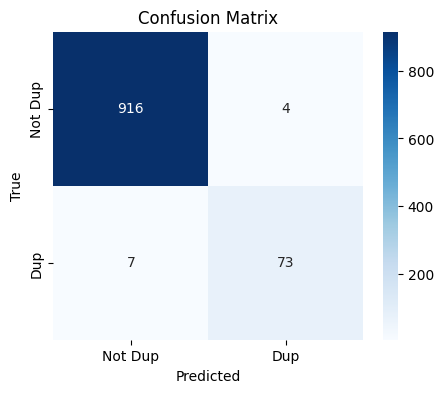

In [51]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(
    y_test, y_pred,
    target_names=['Not Duplicate','Duplicate']
))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Not Dup','Dup'],
    yticklabels=['Not Dup','Dup']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
